# Import and High-Level Setup

In [1]:
# General Python Packages
import os, time, numbers, math

# Torch Packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torch import nn
from torch.nn import DataParallel
from torch.nn import Module

# General Analytics Packages
import pandas as pd
import numpy as np

# Visualization / Image Packages
import matplotlib.pyplot as plt
from PIL import Image

# Randomization Functions
from random import random as randuni

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
# Put MatPlotLib in interactive mode
plt.ion()

# Plot graphics inline in the notebook
%matplotlib inline

# Define Data Manipulation Classes

### Helper Utility Classes

In [3]:
def is_image_file(fname):
    """Checks if a file is an image.
    Args:
        fname (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return fname.lower().endswith('.png')

def create_label_maps(details_df):
    """ Take a descriptive dataframe and extract the unique labels and map to index values
    Args:
        details_df: Dataframe with the image details
    Returns:
        label_list: list of unique labels in the dataframe
        label_to_index: map from labels to indices
    """
    """ TODO: Research paper also excludes these labels but need to figure out how to handle
              cases that have these as positive findings (completely exclude?)
    excluded_labels = ['Edema','Hernia','Emphysema','Fibrosis','No Finding'
                      'Pleural_Thickening','Consolidation']
    """
    excluded_labels = ['No Finding']
    
    label_groups = details_df['Finding Labels'].unique()
    unique_labels = set([label for sublist in label_groups.tolist() for label in sublist.split('|')])
    
    # Drop some label that we do not want to include
    unique_labels = [l for l in unique_labels if l not in excluded_labels]

    index_to_label = {idx: val for idx, val in enumerate(unique_labels)}
    label_to_index = {val: idx for idx, val in index_to_label.items()}

    label_list = list(label_to_index.keys())

    return label_list, label_to_index

def create_image_list(dir):
    """ Create a full list of images available 
    Args:
        dir (string): root directory of images with subdirectories underneath
                      that have the .png images within them
    Returns:
        image_list: list of tuples with (image_name, full_image_path)
    """
    image_list = []
    dir = os.path.expanduser(dir)
    for subfolder in sorted(os.listdir(dir)):
        d = os.path.join(dir, subfolder)
        if not os.path.isdir(d):
            continue
        for subfolder_path, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(subfolder_path, fname)
                    image_list.append((fname, path))
    return image_list

def pil_loader(path):
    """ Opens path as file with Pillow (https://github.com/python-pillow/Pillow/issues/835)
    Args:
        path (string): File path to the image
    Returns:
        img: Image in RGB format
    """
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
def imshow(inp, title=None):
    """ Convert tensor array to an image (only use post-dataset transform) """
    inp = inp[0]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Implementation of Torch's Dataset

In [4]:
class XrayImageSet(Dataset):
    """
    Args:
        image_root (string): root directory of the images in form image/subfolder/*.png
        csv_file (string): path to the CSV data file
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        labels (list): list of the possible label names.
        label_to_index (dict): look from label name to a label index
        imgs (list): List of (filename, image path) tuples
    """
    
    def __init__(self, image_root, csv_file, transform=None, target_transform=None, loader = pil_loader):
        """ Create an instance of the Xray Dataset """
        img_details = pd.read_csv(csv_file)
        
        labels, label_to_index = create_label_maps(img_details)
        imgs = create_image_list(image_root)

        self.imgs = imgs
        self.image_details = img_details
        self.image_root = image_root
        self.labels = labels
        self.label_to_index = label_to_index
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.max_label_index = max(label_to_index.values())

    def __getitem__(self, index):
        """ Get image,labels pair by index
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        fname, path = self.imgs[index]
        target = self.get_one_hot_labels(fname)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """ Calculate length of the dataset (number of images) """
        return len(self.imgs)
    
    def get_labels(self, fname):
        """ Return the label string for the file """
        return self.image_details[self.image_details['Image Index'] == fname]['Finding Labels'].values[0]
    
    def one_hot_labels(self, labels):
        """ Convert the labels string (with each label separated by |) into 1-hot encoding """
        if labels == None:
            return None
        
        split_label_indices = [self.label_to_index.get(label)
                               for label in labels.split('|')
                               if label != 'No Finding']
        
        out = [1 if idx in split_label_indices else 0 for idx in range(self.max_label_index+1)]
        # This code UNHOTs the labels:
        # out = '|'.join([index_to_label.get(idx) for idx, val in enumerate(one_hot_tuple) if val == 1])
        return out

    def get_one_hot_labels(self, fname):
        """ Get the 1-hot encoded label array for the provided file """
        labels = self.get_labels(fname)
        one_hot_labels = self.one_hot_labels(labels)
        return torch.FloatTensor(one_hot_labels)

#### mean ± std. dev. of 7 runs, 10000000 loops each

#### Time for __get_item__
```
%timeit img_data_train[3] # 30.8 ms ± 544 µs per loop
```

#### Breakdown for __get_item__
```
%timeit img_data_train.imgs[8] # 63 ns ± 0.0057 ns per loop
%timeit img_data_train.get_one_hot_labels('00011558_012.png') # 8.72 ms ± 9.44 µs per loop
%timeit img_data_train.loader('/user/images/images_006/00011558_012.png') # 14.1 ms ± 3.41 µs per loop
%timeit img_data_train.transform(img) # 3.17 ms ± 1.32 µs per loop
```

#### Breakdown for loader() from __get_item__
```
%timeit open('/user/images/images_006/00011558_012.png', 'rb') # 7.72 µs ± 13.4 ns per loop
%timeit Image.open(f) # 37.5 µs ± 2.25 µs per loop
%timeit img.convert('RGB') # 498 µs ± 149 ns per loop
```

### Create the dataset with necessary transformations

In [5]:
nn_input_size = 224
#nn_input_size = 1024

In [6]:
img_transforms = transforms.Compose(
    [transforms.Resize(nn_input_size),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [7]:
img_data_train = XrayImageSet(image_root = '/user/images/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms,
                              target_transform = None)

img_data_train.imgs = [img for i, img in enumerate(img_data_train.imgs) if i % 10 > 0]# and randuni() < 0.1]

In [8]:
img_data_val   = XrayImageSet(image_root = '/user/images/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms,
                              target_transform = None)

img_data_val.imgs = [img for i, img in enumerate(img_data_val.imgs) if i % 10 == 0]# and randuni() < 0.1]

In [9]:
print("Training Set Size: {}".format(len(img_data_train)))
print("Validation Set Size: {}".format(len(img_data_val)))

Training Set Size: 100908
Validation Set Size: 11212


### Put the dataset into a Dataloader to handle batching

In [10]:
batch_size = 64
num_gpus = torch.cuda.device_count()
pin_mem_setting = True

print("Number of GPU: {}".format(num_gpus))

Number of GPU: 1


In [11]:
img_loader_train = DataLoader(img_data_train,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = 10,
                              pin_memory = pin_mem_setting)

img_loader_val   = DataLoader(img_data_val,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = 10,
                              pin_memory = pin_mem_setting)

In [12]:
dataloaders = {
    'train': img_loader_train,
    'val': img_loader_val
}

# Define model training procedure

In [13]:
class printer_writer:
    def __init__(self, output_folder_path):
        self.start_time = time.strftime('%Y%m%d-%Hh%Mm%Ss')
        
        self.outprefix = output_folder_path + '/' + self.start_time
        
        # Print Output File
        self.print_out_path = self.outprefix + '_print.txt'
        self.print_out_file = open(self.print_out_path, 'w', 1)
        
    def printw(self, string):
        print(string)
        try:
            self.print_out_file.write(string + "\n")
        except: # Ignore errors
            pass
        
    def save_checkpoint(self, epoch, model, optimizer, scheduler, val_error):
        model_out_path = self.outprefix + '_model_' + str(epoch+1) + '.tar'
        
        torch.save({
            'epoch': epoch+1,
            'state': model.state_dict(),
            'optimizer': optimizer,
            'scheduler': scheduler,
            'val_error': val_error
        }, model_out_path)
        
    def close(self):
        self.print_out_file.close()

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, outfolder = '/user/xrayproj/output/'):
    since = time.time()
    scribe = printer_writer(outfolder)

    for epoch in range(num_epochs):
        scribe.printw('Epoch {}/{}'.format(epoch, num_epochs - 1))
        scribe.printw('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0
            obs_counter = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Store statistics (convert from autograd.Variable to float/int)
                loss_val = loss.data[0]
                correct_val = torch.sum( ((outputs.sigmoid()>0.5) == (labels>0.5)).long() ).data[0]
                
                running_loss += loss_val
                running_corrects += correct_val
                
                obs_counter += len(inputs)
                
                batch_loss = 1.0 * loss_val / len(inputs)
                batch_acc = 1.0 * correct_val / len(inputs)
                status = ' |~~ {}@{}  Loss: {:.6f} Acc: {:.4f}'.format(
                    phase, obs_counter, batch_loss, batch_acc)
                scribe.printw(status)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            scribe.printw('{}  Loss: {:.6f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                scribe.save_checkpoint(epoch, model, optimizer, scheduler, epoch_loss)

    time_elapsed = time.time() - since
    scribe.printw('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    scribe.close()

    return model

# Define Weighted Cost Metrics

In [15]:
def imbalance_weighted_bce_with_logit(input, target, size_average=True):
    if not (target.size() == input.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

    max_val = (-input).clamp(min=0)
    loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

    # Determine |P| and |N|
    positive_labels = target.sum()
    negative_labels = (1-target).sum()

    # Upweight the less common class (very often the 1s)
    beta_p = (positive_labels + negative_labels) / positive_labels
    beta_n = (positive_labels + negative_labels) / negative_labels

    # Adjust the losses accordingly
    loss_weight = target * beta_p + (1-target) * beta_n
    
    loss = loss * loss_weight

    if size_average:
        return loss.mean()
    else:
        return loss.sum()

In [16]:
class BCEWithLogitsImbalanceWeightedLoss(Module):
    def __init__(self, class_weight=None, size_average=True):
        super(BCEWithLogitsImbalanceWeightedLoss, self).__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return imbalance_weighted_bce_with_logit(input, target, size_average=self.size_average)

# Setup Neural Network

### Define the model specifications

In [17]:
def ResNet18PlusFlexibleFC():
    # Create a base ResNet18 model
    m = models.resnet18(pretrained=True)
    for param in m.parameters():
        param.requires_grad = False

    # Replace the final FC layer
    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [18]:
def ResNet50PlusFlexibleFC():
    # Create a base ResNet18 model
    m = models.resnet50(pretrained=True)
    for param in m.parameters():
        param.requires_grad = False

    # Replace the final FC layer
    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [19]:
def ResNet18PlusFCFullyFlexible():
    # Create a base ResNet18 model
    m = models.resnet18(pretrained=True)

    # Replace the final FC layer
    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [105]:
def BrandNewArchitecture():
    m = nn.Sequential(
            nn.Conv2d(1, 8, 2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Linear(H, D_out)
        )
    
    return m

### Pull the ResNet-18 pre-trained model and replace the fully connected layer at the end

In [22]:
#model_base = ResNet18PlusFlexibleFC()
#model_base = ResNet18PlusFCFullyFlexible()
model_base = ResNet50PlusFlexibleFC()

### Push model to CUDA/GPU

In [23]:
model_ft = DataParallel(model_base).cuda()

### Define loss measure and learning rates/procedures

In [24]:
#criterion = BCEWithLogitsImbalanceWeightedLoss()
criterion_base = nn.BCEWithLogitsLoss()

optimizer_ft = SGD(model_ft.module.fc.parameters(), lr=0.0001, momentum=0.9)
#optimizer_ft = SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
criterion = criterion_base.cuda()

### Future code for allowing optimization of the base layer with a lower learning rate

```
ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': opt.lr}
        ], lr=opt.lr*0.1, momentum=0.9)
```

# Begin Training Network (Normal Cost)

In [126]:
train_model(model_ft,
            criterion,
            optimizer_ft,
            exp_lr_scheduler,
            num_epochs=1)

Epoch 0/0
----------
 |~~ train@64  Loss: 0.002631 Acc: 13.3594
 |~~ train@128  Loss: 0.002757 Acc: 13.3125
 |~~ train@192  Loss: 0.002843 Acc: 13.2500
 |~~ train@256  Loss: 0.002862 Acc: 13.2969
 |~~ train@320  Loss: 0.002213 Acc: 13.4688
 |~~ train@384  Loss: 0.002902 Acc: 13.2031
 |~~ train@448  Loss: 0.003050 Acc: 13.1719
 |~~ train@512  Loss: 0.002764 Acc: 13.2656
 |~~ train@576  Loss: 0.003300 Acc: 13.1562
 |~~ train@640  Loss: 0.002788 Acc: 13.2031
 |~~ train@704  Loss: 0.002858 Acc: 13.2188
 |~~ train@768  Loss: 0.002469 Acc: 13.4375
 |~~ train@832  Loss: 0.002596 Acc: 13.3906
 |~~ train@896  Loss: 0.003316 Acc: 13.0938
 |~~ train@960  Loss: 0.002297 Acc: 13.4219
 |~~ train@1024  Loss: 0.002222 Acc: 13.5000
 |~~ train@1088  Loss: 0.002559 Acc: 13.3438
 |~~ train@1152  Loss: 0.002611 Acc: 13.3594
 |~~ train@1216  Loss: 0.002324 Acc: 13.4062
 |~~ train@1280  Loss: 0.003265 Acc: 13.1094
 |~~ train@1344  Loss: 0.002881 Acc: 13.2969
 |~~ train@1408  Loss: 0.002452 Acc: 13.4375
 |~~ 

 |~~ train@11712  Loss: 0.002242 Acc: 13.4531
 |~~ train@11776  Loss: 0.003303 Acc: 13.1250
 |~~ train@11840  Loss: 0.002930 Acc: 13.2031
 |~~ train@11904  Loss: 0.003782 Acc: 12.9844
 |~~ train@11968  Loss: 0.003196 Acc: 13.1875
 |~~ train@12032  Loss: 0.002922 Acc: 13.2188
 |~~ train@12096  Loss: 0.003647 Acc: 13.0312
 |~~ train@12160  Loss: 0.002699 Acc: 13.3594
 |~~ train@12224  Loss: 0.003165 Acc: 13.1562
 |~~ train@12288  Loss: 0.003340 Acc: 13.1094
 |~~ train@12352  Loss: 0.003029 Acc: 13.2344
 |~~ train@12416  Loss: 0.002504 Acc: 13.3906
 |~~ train@12480  Loss: 0.002226 Acc: 13.5000
 |~~ train@12544  Loss: 0.002549 Acc: 13.3750
 |~~ train@12608  Loss: 0.003120 Acc: 13.2656
 |~~ train@12672  Loss: 0.002875 Acc: 13.2344
 |~~ train@12736  Loss: 0.002745 Acc: 13.3594
 |~~ train@12800  Loss: 0.003353 Acc: 13.1094
 |~~ train@12864  Loss: 0.003285 Acc: 13.1562
 |~~ train@12928  Loss: 0.002637 Acc: 13.3438
 |~~ train@12992  Loss: 0.002930 Acc: 13.2656
 |~~ train@13056  Loss: 0.002881 A

 |~~ train@23232  Loss: 0.003002 Acc: 13.2188
 |~~ train@23296  Loss: 0.002400 Acc: 13.4688
 |~~ train@23360  Loss: 0.003325 Acc: 13.1250
 |~~ train@23424  Loss: 0.002858 Acc: 13.2812
 |~~ train@23488  Loss: 0.002584 Acc: 13.3438
 |~~ train@23552  Loss: 0.002386 Acc: 13.4844
 |~~ train@23616  Loss: 0.003304 Acc: 13.1719
 |~~ train@23680  Loss: 0.002744 Acc: 13.3438
 |~~ train@23744  Loss: 0.002588 Acc: 13.3438
 |~~ train@23808  Loss: 0.002459 Acc: 13.3438
 |~~ train@23872  Loss: 0.002819 Acc: 13.2969
 |~~ train@23936  Loss: 0.002737 Acc: 13.2812
 |~~ train@24000  Loss: 0.002556 Acc: 13.3750
 |~~ train@24064  Loss: 0.003042 Acc: 13.2344
 |~~ train@24128  Loss: 0.002662 Acc: 13.3125
 |~~ train@24192  Loss: 0.002807 Acc: 13.3594
 |~~ train@24256  Loss: 0.003041 Acc: 13.2188
 |~~ train@24320  Loss: 0.002305 Acc: 13.4219
 |~~ train@24384  Loss: 0.002700 Acc: 13.3750
 |~~ train@24448  Loss: 0.002693 Acc: 13.3281
 |~~ train@24512  Loss: 0.002990 Acc: 13.1875
 |~~ train@24576  Loss: 0.002591 A

 |~~ train@34688  Loss: 0.002741 Acc: 13.3125
 |~~ train@34752  Loss: 0.002927 Acc: 13.2344
 |~~ train@34816  Loss: 0.002670 Acc: 13.3125
 |~~ train@34880  Loss: 0.002526 Acc: 13.4062
 |~~ train@34944  Loss: 0.003385 Acc: 13.0781
 |~~ train@35008  Loss: 0.002806 Acc: 13.2656
 |~~ train@35072  Loss: 0.002255 Acc: 13.5000
 |~~ train@35136  Loss: 0.002392 Acc: 13.4062
 |~~ train@35200  Loss: 0.002483 Acc: 13.4531
 |~~ train@35264  Loss: 0.003093 Acc: 13.1875
 |~~ train@35328  Loss: 0.002588 Acc: 13.3594
 |~~ train@35392  Loss: 0.003127 Acc: 13.2031
 |~~ train@35456  Loss: 0.002786 Acc: 13.2656
 |~~ train@35520  Loss: 0.002647 Acc: 13.3594
 |~~ train@35584  Loss: 0.003144 Acc: 13.1562
 |~~ train@35648  Loss: 0.003401 Acc: 13.1094
 |~~ train@35712  Loss: 0.002663 Acc: 13.3750
 |~~ train@35776  Loss: 0.002551 Acc: 13.3594
 |~~ train@35840  Loss: 0.002440 Acc: 13.4219
 |~~ train@35904  Loss: 0.003315 Acc: 13.0781
 |~~ train@35968  Loss: 0.002913 Acc: 13.2812
 |~~ train@36032  Loss: 0.002786 A

 |~~ train@46144  Loss: 0.002509 Acc: 13.4219
 |~~ train@46208  Loss: 0.002846 Acc: 13.2969
 |~~ train@46272  Loss: 0.002730 Acc: 13.3594
 |~~ train@46336  Loss: 0.002839 Acc: 13.2812
 |~~ train@46400  Loss: 0.002848 Acc: 13.3594
 |~~ train@46464  Loss: 0.002334 Acc: 13.4531
 |~~ train@46528  Loss: 0.002952 Acc: 13.2656
 |~~ train@46592  Loss: 0.002843 Acc: 13.2969
 |~~ train@46656  Loss: 0.002891 Acc: 13.3281
 |~~ train@46720  Loss: 0.002506 Acc: 13.3906
 |~~ train@46784  Loss: 0.003253 Acc: 13.1719
 |~~ train@46848  Loss: 0.002637 Acc: 13.2812
 |~~ train@46912  Loss: 0.002751 Acc: 13.3125
 |~~ train@46976  Loss: 0.003001 Acc: 13.2656
 |~~ train@47040  Loss: 0.002590 Acc: 13.3594
 |~~ train@47104  Loss: 0.003454 Acc: 13.0938
 |~~ train@47168  Loss: 0.002717 Acc: 13.3125
 |~~ train@47232  Loss: 0.002828 Acc: 13.2656
 |~~ train@47296  Loss: 0.002619 Acc: 13.3906
 |~~ train@47360  Loss: 0.003032 Acc: 13.2344
 |~~ train@47424  Loss: 0.003272 Acc: 13.0938
 |~~ train@47488  Loss: 0.003034 A

 |~~ train@57600  Loss: 0.002850 Acc: 13.2656
 |~~ train@57664  Loss: 0.002963 Acc: 13.1875
 |~~ train@57728  Loss: 0.002891 Acc: 13.2500
 |~~ train@57792  Loss: 0.003437 Acc: 13.1094
 |~~ train@57856  Loss: 0.002238 Acc: 13.5000
 |~~ train@57920  Loss: 0.003046 Acc: 13.2188
 |~~ train@57984  Loss: 0.002551 Acc: 13.3594
 |~~ train@58048  Loss: 0.002470 Acc: 13.4062
 |~~ train@58112  Loss: 0.002758 Acc: 13.3438
 |~~ train@58176  Loss: 0.002755 Acc: 13.3125
 |~~ train@58240  Loss: 0.002965 Acc: 13.2812
 |~~ train@58304  Loss: 0.002612 Acc: 13.3594
 |~~ train@58368  Loss: 0.002801 Acc: 13.2812
 |~~ train@58432  Loss: 0.002431 Acc: 13.5000
 |~~ train@58496  Loss: 0.002528 Acc: 13.3906
 |~~ train@58560  Loss: 0.003132 Acc: 13.1719
 |~~ train@58624  Loss: 0.003161 Acc: 13.2031
 |~~ train@58688  Loss: 0.003146 Acc: 13.1406
 |~~ train@58752  Loss: 0.003293 Acc: 13.1250
 |~~ train@58816  Loss: 0.002775 Acc: 13.3125
 |~~ train@58880  Loss: 0.003026 Acc: 13.1719
 |~~ train@58944  Loss: 0.002617 A

 |~~ train@69056  Loss: 0.002638 Acc: 13.3594
 |~~ train@69120  Loss: 0.002460 Acc: 13.3906
 |~~ train@69184  Loss: 0.003168 Acc: 13.1562
 |~~ train@69248  Loss: 0.002906 Acc: 13.2812
 |~~ train@69312  Loss: 0.002559 Acc: 13.3594
 |~~ train@69376  Loss: 0.002646 Acc: 13.3594
 |~~ train@69440  Loss: 0.002840 Acc: 13.2344
 |~~ train@69504  Loss: 0.002720 Acc: 13.2969
 |~~ train@69568  Loss: 0.002859 Acc: 13.2344
 |~~ train@69632  Loss: 0.002477 Acc: 13.4062
 |~~ train@69696  Loss: 0.002149 Acc: 13.4844
 |~~ train@69760  Loss: 0.002751 Acc: 13.3125
 |~~ train@69824  Loss: 0.002802 Acc: 13.2812
 |~~ train@69888  Loss: 0.002598 Acc: 13.3281
 |~~ train@69952  Loss: 0.002507 Acc: 13.3125
 |~~ train@70016  Loss: 0.002646 Acc: 13.3281
 |~~ train@70080  Loss: 0.002113 Acc: 13.5312
 |~~ train@70144  Loss: 0.002608 Acc: 13.3750
 |~~ train@70208  Loss: 0.003112 Acc: 13.1562
 |~~ train@70272  Loss: 0.002956 Acc: 13.1719
 |~~ train@70336  Loss: 0.003090 Acc: 13.1562
 |~~ train@70400  Loss: 0.002649 A

 |~~ train@80512  Loss: 0.002854 Acc: 13.3281
 |~~ train@80576  Loss: 0.002648 Acc: 13.3594
 |~~ train@80640  Loss: 0.002977 Acc: 13.2656
 |~~ train@80704  Loss: 0.002958 Acc: 13.2344
 |~~ train@80768  Loss: 0.002740 Acc: 13.2656
 |~~ train@80832  Loss: 0.002779 Acc: 13.3125
 |~~ train@80896  Loss: 0.002643 Acc: 13.3594
 |~~ train@80960  Loss: 0.002542 Acc: 13.3750
 |~~ train@81024  Loss: 0.002459 Acc: 13.3438
 |~~ train@81088  Loss: 0.003346 Acc: 13.1250
 |~~ train@81152  Loss: 0.003282 Acc: 13.1406
 |~~ train@81216  Loss: 0.002691 Acc: 13.2500
 |~~ train@81280  Loss: 0.002810 Acc: 13.2656
 |~~ train@81344  Loss: 0.002870 Acc: 13.2500
 |~~ train@81408  Loss: 0.002692 Acc: 13.2656
 |~~ train@81472  Loss: 0.002927 Acc: 13.2188
 |~~ train@81536  Loss: 0.003542 Acc: 13.0156
 |~~ train@81600  Loss: 0.003376 Acc: 13.1094
 |~~ train@81664  Loss: 0.002893 Acc: 13.2656
 |~~ train@81728  Loss: 0.002419 Acc: 13.4531
 |~~ train@81792  Loss: 0.002943 Acc: 13.2031
 |~~ train@81856  Loss: 0.001838 A

 |~~ train@91968  Loss: 0.002761 Acc: 13.3125
 |~~ train@92032  Loss: 0.002950 Acc: 13.2344
 |~~ train@92096  Loss: 0.003116 Acc: 13.1875
 |~~ train@92160  Loss: 0.002812 Acc: 13.2344
 |~~ train@92224  Loss: 0.002974 Acc: 13.2656
 |~~ train@92288  Loss: 0.002783 Acc: 13.3125
 |~~ train@92352  Loss: 0.002969 Acc: 13.2656
 |~~ train@92416  Loss: 0.003040 Acc: 13.2188
 |~~ train@92480  Loss: 0.002840 Acc: 13.2812
 |~~ train@92544  Loss: 0.002787 Acc: 13.2656
 |~~ train@92608  Loss: 0.002728 Acc: 13.2188
 |~~ train@92672  Loss: 0.002702 Acc: 13.3281
 |~~ train@92736  Loss: 0.002625 Acc: 13.3281
 |~~ train@92800  Loss: 0.002143 Acc: 13.5312
 |~~ train@92864  Loss: 0.002854 Acc: 13.2656
 |~~ train@92928  Loss: 0.002571 Acc: 13.3750
 |~~ train@92992  Loss: 0.002615 Acc: 13.3750
 |~~ train@93056  Loss: 0.003322 Acc: 13.0469
 |~~ train@93120  Loss: 0.003157 Acc: 13.0938
 |~~ train@93184  Loss: 0.002664 Acc: 13.3438
 |~~ train@93248  Loss: 0.003475 Acc: 13.0312
 |~~ train@93312  Loss: 0.002907 A

 |~~ val@2624  Loss: 0.002771 Acc: 13.2969
 |~~ val@2688  Loss: 0.002790 Acc: 13.2656
 |~~ val@2752  Loss: 0.003167 Acc: 13.1875
 |~~ val@2816  Loss: 0.002925 Acc: 13.2656
 |~~ val@2880  Loss: 0.003084 Acc: 13.1875
 |~~ val@2944  Loss: 0.002480 Acc: 13.3906
 |~~ val@3008  Loss: 0.002896 Acc: 13.2656
 |~~ val@3072  Loss: 0.002290 Acc: 13.4531
 |~~ val@3136  Loss: 0.002972 Acc: 13.1562
 |~~ val@3200  Loss: 0.002516 Acc: 13.3594
 |~~ val@3264  Loss: 0.003102 Acc: 13.1562
 |~~ val@3328  Loss: 0.003225 Acc: 13.1406
 |~~ val@3392  Loss: 0.002494 Acc: 13.4062
 |~~ val@3456  Loss: 0.002860 Acc: 13.2500
 |~~ val@3520  Loss: 0.003643 Acc: 13.0156
 |~~ val@3584  Loss: 0.002747 Acc: 13.3594
 |~~ val@3648  Loss: 0.002415 Acc: 13.4219
 |~~ val@3712  Loss: 0.002421 Acc: 13.3438
 |~~ val@3776  Loss: 0.002148 Acc: 13.4219
 |~~ val@3840  Loss: 0.002950 Acc: 13.2812
 |~~ val@3904  Loss: 0.002890 Acc: 13.2188
 |~~ val@3968  Loss: 0.002996 Acc: 13.2656
 |~~ val@4032  Loss: 0.002826 Acc: 13.2656
 |~~ val@40

DataParallel(
  (module): ResNet(
    (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, ep

### Save model results to S3

aws s3 cp ResNet18PlusFlexibleFC_Epoch9.tar s3://bdh-xrayproj-modelparameters/

import boto3

s3 = boto3.client('s3')
s3.list_buckets()

S3 Commands: http://docs.aws.amazon.com/cli/latest/userguide/using-s3-commands.html

Boto3 QuickStart: http://boto3.readthedocs.io/en/latest/guide/quickstart.html

Key Management: https://aws.amazon.com/blogs/security/a-safer-way-to-distribute-aws-credentials-to-ec2/

AWS IAM Rules: http://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_use_switch-role-api.html

### Load model results back from S3

In [26]:
exp_lr_scheduler.last_epoch

9

# Analysis of Model Results

In [88]:
class TotalSumMeter:
    def __init__(self):
        self.obs_counter = 0.0
        self.total_pred = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        self.total_act = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        
    def update(self, preds, actuals):
        self.total_act += actuals.sum(0).cpu()
        self.total_pred += preds.sum(0).cpu()
        self.obs_counter += len(actuals)
        
    def get_results(self):
        return {
            'pred': self.total_pred / self.obs_counter,
            'act': self.total_act / self.obs_counter
            }

In [27]:
class MultiClassAUCMeter:
    """ Wrapper on the normal AUCMeter to handle multi-class predictions """
    def __init__(self, num_class):
        self.num_class = num_class
        self.meters = []
        for i in range(self.num_class):
            self.meters.append(AUCMeter())

    def add(self, output, target):
        for i in range(self.num_class):
            self.meters[i].add(output[:,i], target[:,i])
        
    def value(self):
        output = []
        for i in range(self.num_class):
            output.append(self.meters[i].value())
        return output

In [28]:
class AUCMeter:
    """
    SOURCE: https://github.com/pytorch/tnt/blob/master/torchnet/meter/aucmeter.py
    
    The AUCMeter measures the area under the receiver-operating characteristic
    (ROC) curve for binary classification problems. The area under the curve (AUC)
    can be interpreted as the probability that, given a randomly selected positive
    example and a randomly selected negative example, the positive example is
    assigned a higher score by the classification model than the negative example.
    The AUCMeter is designed to operate on one-dimensional Tensors `output`
    and `target`, where (1) the `output` contains model output scores that ought to
    be higher when the model is more convinced that the example should be positively
    labeled, and smaller when the model believes the example should be negatively
    labeled (for instance, the output of a signoid function); and (2) the `target`
    contains only values 0 (for negative examples) and 1 (for positive examples).
    """
    def __init__(self):
        super(AUCMeter, self).__init__()
        self.reset()

    def reset(self):
        self.scores = torch.DoubleTensor(torch.DoubleStorage()).numpy()
        self.targets = torch.LongTensor(torch.LongStorage()).numpy()

    def add(self, output, target):
        if torch.is_tensor(output):
            output = output.cpu().squeeze().numpy()
        if torch.is_tensor(target):
            target = target.cpu().squeeze().numpy()
        elif isinstance(target, numbers.Number):
            target = np.asarray([target])
        assert np.ndim(output) == 1, \
            'wrong output size (1D expected)'
        assert np.ndim(target) == 1, \
            'wrong target size (1D expected)'
        assert output.shape[0] == target.shape[0], \
            'number of outputs and targets does not match'
        assert np.all(np.add(np.equal(target, 1), np.equal(target, 0))), \
            'targets should be binary (0, 1)'

        self.scores = np.append(self.scores, output)
        self.targets = np.append(self.targets, target)

    def value(self):
        # case when number of elements added are 0
        if self.scores.shape[0] == 0:
            return 0.5

        # sorting the arrays
        scores, sortind = torch.sort(torch.from_numpy(self.scores), dim=0, descending=True)
        scores = scores.numpy()
        sortind = sortind.numpy()

        # creating the roc curve
        tpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)
        fpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)

        for i in range(1, scores.size + 1):
            if self.targets[sortind[i - 1]] == 1:
                tpr[i] = tpr[i - 1] + 1
                fpr[i] = fpr[i - 1]
            else:
                tpr[i] = tpr[i - 1]
                fpr[i] = fpr[i - 1] + 1

        tpr /= (self.targets.sum() * 1.0)
        fpr /= ((self.targets - 1.0).sum() * -1.0)

        # calculating area under curve using trapezoidal rule
        n = tpr.shape[0]
        h = fpr[1:n] - fpr[0:n - 1]
        sum_h = np.zeros(fpr.shape)
        sum_h[0:n - 1] = h
        sum_h[1:n] += h
        area = (sum_h * tpr).sum() / 2.0

        return (area, tpr, fpr)

In [29]:
class ModelEvaluator:
    def __init__(self, model, dataset, num_classes = 14):
        self.model = model
        self.dataset = dataset
        self.num_classes = num_classes
        self.is_run = False
        
    def score_obs(self, data_row):
        inputs, actuals = data_row

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()
        
        return preds, actuals
    
    def run(self, force_rerun = False):
        if self.is_run and not force_rerun:
            print("Already evaluated this...")
            return None
        
        self.model.train(False)
    
        self.m_total_sums = TotalSumMeter()
        self.m_auc = MultiClassAUCMeter(self.num_classes)

        for data in self.dataset:
            preds, actuals = self.score_obs(data)

            self.m_total_sums.update(preds, actuals)
            self.m_auc.add(preds.data, actuals.data)

In [37]:
def plot_auc_bar(in_evaluator):
    auc_out = in_evaluator.m_auc.value()
    plt.bar(range(14), [v for v, _, _ in auc_out])

In [134]:
def plot_auc_curves(in_evaluator):
    index_to_label = {idx: val for val, idx in img_data_train.label_to_index.items()}
    auc_out = in_evaluator.m_auc.value()
    
    plt.figure(figsize=(10,8))

    for idx, (auc, tpr, fpr) in enumerate(auc_out):
        disease = index_to_label[idx]
        plt.plot(fpr, tpr, label="{0} (AUC: {1:0.2f})".format(disease, auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve by Disease Type')
    plt.legend(loc="lower right")
    plt.show()

In [115]:
def plot_compare_sums(in_evaluator, bar_width = 0.4):
    sums_out = in_evaluator.m_total_sums.get_results()
    
    act = sums_out['act'].data.numpy()
    pred = sums_out['pred'].data.numpy()
    
    indx1 = range(14)
    indx2 = [i+bar_width for i in indx1]

    plt.bar(indx1, act,  width=bar_width, label="Actual")
    plt.bar(indx2, pred, width=bar_width, label="Predicted")
    
    plt.xticks(indx1, img_data_train.labels, rotation=90)
    plt.legend()

In [131]:
epoch_evals = {}

In [132]:
epoch = exp_lr_scheduler.last_epoch

epoch_evals[epoch] = {}

epoch_evals[epoch]['val'] = ModelEvaluator(model_ft, dataloaders['val'])
#epoch_evals[epoch]['train'] = ModelEvaluator(model_ft, dataloaders['train'])

epoch_evals[epoch]['val'].run()
#epoch_evals[epoch]['train'].run()

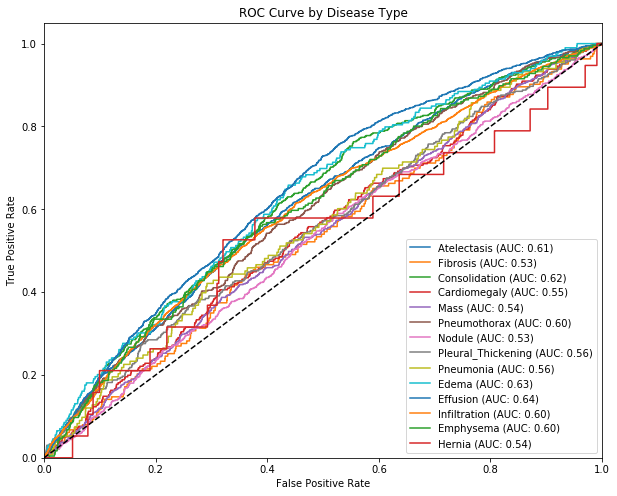

In [135]:
plot_auc_curves(epoch_evals[2]['val'])

Text(0.5,1,'Validation Sums')

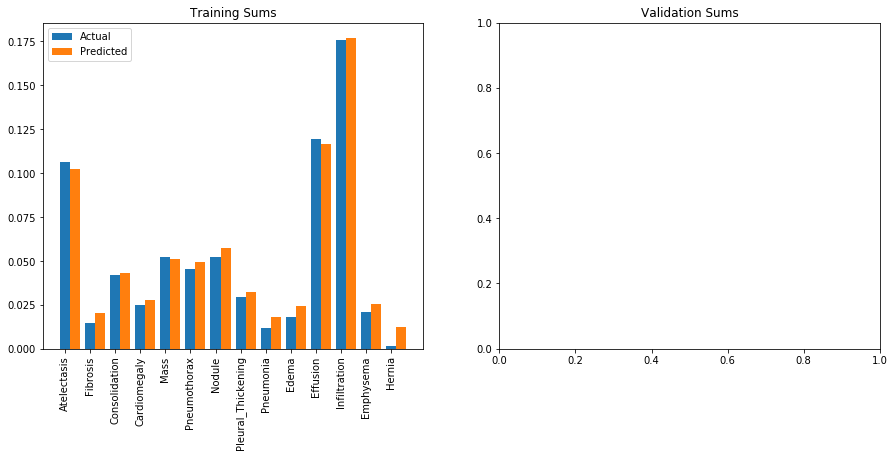

In [125]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Training Sums")
plot_compare_sums(epoch1_eval_val)

plt.subplot(1,2,2)
plt.title("Validation Sums")
#plot_compare_sums(epoch1_eval_train)

In [54]:
out_model_30.train(mode=False)

obs_counter = 0
total_pred = Variable(torch.FloatTensor(torch.zeros(14)))
total_act = Variable(torch.FloatTensor(torch.zeros(14)))

conf_a = {}
conf_b = {}
conf_c = {}
conf_d = {}
for i in range(1,10):
    conf_a[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_b[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_c[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_d[i] = Variable(torch.FloatTensor(torch.zeros(14)))

for data in dataloaders['val']:
    print("STARTING ITERATION...")
    inputs, labels = data
    print("PROCESSING FIRST {} OBSERVATIONS".format(len(inputs)))

    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    outputs = out_model_30(inputs).sigmoid()
    
    total_act += labels.sum(0).cpu()
    total_pred += outputs.sum(0).cpu()

    # Store statistics (convert from autograd.Variable to float/int)
    for i in range(1,10):
        t = i/10
        conf_a[i] += ((outputs.sigmoid()>t) == (labels>0.5)).sum(0).cpu().float()
        conf_b[i] += ((outputs.sigmoid()<t) == (labels>0.5)).sum(0).cpu().float()
        conf_c[i] += ((outputs.sigmoid()>t) == (labels<0.5)).sum(0).cpu().float()
        conf_d[i] += ((outputs.sigmoid()<t) == (labels<0.5)).sum(0).cpu().float()

    obs_counter += len(inputs)

STARTING ITERATION...
PROCESSING FIRST 750 OBSERVATIONS
STARTING ITERATION...
PROCESSING FIRST 406 OBSERVATIONS


In [67]:
comparison = Variable(torch.FloatTensor(9, 14))
for i in range(9):
    comparison[0] = conf_a[1] / obs_counter
print(comparison.int())

Variable containing:

Columns 0 to 5 
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -2.1475e+09  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00 -2.1475e+09  0.0000e+00 -2.1475e+09  0.0000e+00
 6.2634e+06 -1.0000e+00 -2.1475e+09  0.0000e+00 -2.1475e+09  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00

Columns 6 to 11 
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -6.5460e+04  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
-2.1475e

In [101]:
'''
torch.save({
            'epoch': epoch+1,
            'state': model.state_dict(),
            'optimizer': optimizer,
            'scheduler': scheduler,
            'val_error': val_error
        }, model_out_path)
'''
test_load = torch.load('/user/xrayproj/output/20171120-01h41m56s_model_9.tar')

In [103]:
test_load.keys()

dict_keys(['epoch', 'state', 'optimizer', 'scheduler', 'val_error'])

In [106]:
load_opt = test_load['optimizer']
load_sched = test_load['scheduler']
load_state = test_load['state']

In [117]:
model2 = models.resnet18(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Replace FC layer
model2.fc = nn.Linear(model2.fc.in_features, len(img_data_train.labels))

model2_c = DataParallel(model2).cuda()

In [118]:
model2_c.load_state_dict(load_state)

In [123]:
model2_c.forward(Variable(img_data_train[0][0].unsqueeze(0).cuda())).sigmoid()

Variable containing:

Columns 0 to 9 
 0.7873  0.5093  0.2980  0.6386  0.4665  0.3371  0.1614  0.1846  0.1925  0.6630

Columns 10 to 13 
 0.0288  0.4468  0.3684  0.2549
[torch.cuda.FloatTensor of size 1x14 (GPU 0)]

In [ ]:
def single_model_run(model, dataset):
    dataset
    for data in self.dataset:
        inputs, actuals = data

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()

        self.m_total_sums.update(preds, actuals)
        self.m_auc.add(preds, actuals)